In [1]:
import cooler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import h5py
import pickle
import seaborn as sns
import tqdm

from scipy import stats

from statsmodels.stats.multitest import multipletests

import sys
import itertools
import time

sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
from __init__ import *
from __init__jupyterlab import * 
import snmcseq_utils

In [2]:
default_colorbar_kws = DEFAULT_COLORBAR_KWS

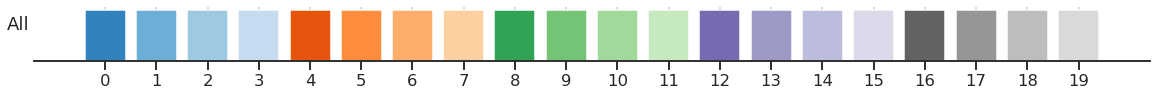

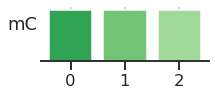

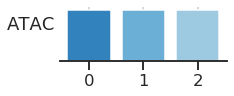

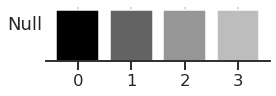

In [3]:
# color palette
cm = plt.cm.tab20c.colors

# settle down on a color palette
colors_mc = [cm[8], cm[9], cm[10],]
colors_atac = [cm[0], cm[1], cm[2],]
colors_null = ['black', cm[16], cm[17], cm[18],]

color_tracks = [
    cm,
    colors_mc,
    colors_atac,
    colors_null,
]

labels = [
    'All',
    'mC',
    'ATAC',
    'Null',
]

for color_track, label in zip(color_tracks, labels):
    n = len(color_track)
    fig, ax = plt.subplots(figsize=(1*n,1))
    ax.bar(np.arange(n), 1, 
           color=color_track)
    ax.set_xticks(np.arange(n))
    ax.set_ylabel(label, rotation=0, ha='right')
    sns.despine(ax=ax, left=True)
    ax.set_yticks([])
    plt.show()

In [4]:
mod_palette = {
    'mc': 'C2',
    'atac': 'C0',
    'null': 'k',
}

mod_palette_comp = {
    'mc': colors_mc,
    'atac': colors_atac,
    'null': colors_null,
}


KB = 1000
def p25(x):
    return np.percentile(x, 25)
def p75(x):
    return np.percentile(x, 75)


In [5]:
def kth_diag_indices(n, k=0):
    """
    """
    assert k >= 0
    
    row_idx = np.arange(n)
    col_idx = np.arange(n)
    
    col_idx = row_idx + k
    
    if k > 0:
        return row_idx[:-k], col_idx[:-k]
    if k == 0:
        return row_idx, col_idx

def mat_values_kth_diag_indices(mat, k=0):
    """
    """
    return mat[kth_diag_indices(len(mat), k=k)]

In [6]:
def enh_gene_id_to_binidx(_table, tsss, enhs, resolution):
    """
    Given a dataframe of enh-gene pairs (by IDs)
    return which bins in HiC data they correspond to
    
    Return a dataframe with dist_bin as index, 'gene_bin', 'enh_bin' as columns
    """
    # merge gid, enh_id with genome locations
    _tmp = pd.merge(_table, tsss.rename(columns={'chr': 'gene_chr',
                                                 'start': 'gene_start',
                                                 'end': 'gene_end',
                                                 'gid': 'gene',
                                                }), on='gene')

    _tmp = pd.merge(_tmp, enhs.rename(columns={'chr': 'enh_chr',
                                               'start': 'enh_start',
                                               'end': 'enh_end',
                                               'center': 'enh_center',
                                               'enh_id': 'enh',
                                              }), on='enh')
    # find the correct bins
    _tmp['enh_bin'] = (_tmp['enh_center'].values/resolution).astype(int)
    _tmp['gene_bin'] = (_tmp['gene_start'].values/resolution).astype(int)
    _tmp['dist_bin'] = np.abs(_tmp['enh_bin'] - _tmp['gene_bin'])
    _tmp = _tmp.set_index('dist_bin')
    
    return _tmp

In [7]:
def get_contact_stats(mat, paired_bin_tables, resolution, distance_cutoff=1e6):
    """
    """
    distance_idx = np.arange(1, int(distance_cutoff/resolution))
    distances = distance_idx * resolution

    contacts_mean = []
    contacts_std = []
    contacts_sig_pairs_mean = collections.OrderedDict({_label: [] for _label, _table in paired_bin_tables.items()})
    contacts_sig_pairs_std = collections.OrderedDict({_label: [] for _label, _table in paired_bin_tables.items()})

    for i in tqdm.tqdm(distance_idx):
        contacts = mat_values_kth_diag_indices(mat, k=i)
        contacts_mean.append(np.nanmean(contacts)) 
        contacts_std.append(np.nanstd(contacts)) 

        for _label, _table in paired_bin_tables.items():
            try:
                pairs = _table.loc[i]
                contacts_sig_pairs = mat[(pairs['enh_bin'].values, pairs['gene_bin'].values)]
            except:
                contacts_sig_pairs = []

            contacts_sig_pairs_mean[_label].append(np.nanmean(contacts_sig_pairs)) 
            contacts_sig_pairs_std[_label].append(np.nanstd(contacts_sig_pairs)) 

    contacts_mean = np.array(contacts_mean)
    contacts_std = np.array(contacts_std)

    contacts_sig_pairs_mean = collections.OrderedDict({
                    _label: np.array(_table) for _label, _table in contacts_sig_pairs_mean.items()})
    contacts_sig_pairs_std = collections.OrderedDict({
                    _label: np.array(_table) for _label, _table in contacts_sig_pairs_std.items()})

    return (contacts_mean, contacts_std, 
            contacts_sig_pairs_mean, contacts_sig_pairs_std,
           )

def get_contacts(mat, paired_bin_tables, resolution, distance_idx):
    """
    given distances/distance idx; 
    - contacts: a list of numpy arrays
    - contacts_sig_pairs: a dict of list of numpy arrays 
    """

    contacts = []
    contacts_sig_pairs = collections.OrderedDict({_label: [] for _label, _table in paired_bin_tables.items()})

    for i in tqdm.tqdm(distance_idx):
        _contacts = mat_values_kth_diag_indices(mat, k=i)
        contacts.append(_contacts) 

        for _label, _table in paired_bin_tables.items():
            try:
                pairs = _table.loc[i]
                _contacts_sig_pairs = mat[(pairs['enh_bin'].values, pairs['gene_bin'].values)]
            except:
                _contacts_sig_pairs = []
            contacts_sig_pairs[_label].append(_contacts_sig_pairs) 

    return (contacts, contacts_sig_pairs)

In [8]:
def plot_contact_stats(
    chromosome, celltype, resolution,
    distances, contacts_mean, contacts_std, 
    contacts_sig_pairs_mean, contacts_sig_pairs_std, 
    track_names, colors,
    output_fig,
    ):
    """
    """
    
    fig, axs = plt.subplots(2, 4, figsize=(5*4,5*2), sharey=True, sharex=True)

    # all together
    ax = axs[0,0]
    _x, _y, _yerr = distances, contacts_mean, contacts_std
    color='gray'
    ax.plot(_x, _y, '-', color=color, linewidth=3, label='all_bins')
    for i, (_name, _color) in enumerate(zip(track_names, colors)):
        _x, _y, _yerr = distances, contacts_sig_pairs_mean[_name], contacts_sig_pairs_std[_name]
        ax.plot(_x, _y, '-', color=_color, linewidth=3, label=_name)
        
    ax.xaxis.set_major_formatter(mtick.EngFormatter())
    ax.set_yscale('log')
    ax.set_xlabel('Genomic distance')
    ax.set_xlim([0, 1e5])
    ax.set_ylim([1e-3, 1e-1])
    ax.set_ylabel('Contact frequency\n(normalized mean +/- std)')
    ax.set_title("{} {}, {} HiC resolution".format(chromosome, celltype, resolution))

    for ax in axs[0,1:]:
        ax.axis('off')

    # specific plots
    for i, (ax, _name, _color) in enumerate(zip(axs[1], track_names, colors)):
        _x, _y, _yerr = distances, contacts_mean, contacts_std
        color='gray'
        ax.fill_between(_x, _y-_yerr, _y+_yerr, color=color, alpha=0.2)
        ax.plot(_x, _y, '-', color=color, linewidth=5, label='all_bins', alpha=1)

        _x, _y, _yerr = distances, contacts_sig_pairs_mean[_name], contacts_sig_pairs_std[_name]
        ax.fill_between(_x, _y-_yerr, _y+_yerr, color=_color, alpha=0.2)
        ax.plot(_x, _y, '-', color=_color, linewidth=5, label=_name, alpha=1)

        ax.xaxis.set_major_formatter(mtick.EngFormatter())
        ax.set_yscale('log')
        ax.set_xlabel('Genomic distance')
        ax.set_xlim([0, 1e5])
        ax.set_ylim([1e-3, 1e-1])

        if i == 0:
            ax.set_ylabel('Contact frequency\n(normalized mean +/- std)')

    # legends
    handles, labels = snmcseq_utils.combine_legends(axs.flat)
    handles, labels = snmcseq_utils.dedup_legends(handles, labels)
    axs[0,1].legend(handles, labels, bbox_to_anchor=(1,1), loc='upper left')
    
    snmcseq_utils.savefig(fig, output_fig)
    plt.show()
    
    return 

In [9]:
def plot1(distances, celltype, resolution, 
          track_names, colors,
          contacts_mean, contacts_std, contacts_n, 
          contacts_sig_pairs_mean, contacts_sig_pairs_std, contacts_sig_pairs_n,
          output_fig,
         ):
    """
    """
    # plot 
    fig, axs = plt.subplots(2, 4, figsize=(5*4,5*2), sharey=True, sharex=True)

    # all together
    ax = axs[0,0]
    _x, _y, _yerr = distances, contacts_mean, contacts_std*1.96/np.sqrt(contacts_n)
    color='gray'
    ax.plot(_x, _y, '-', color=color, linewidth=3, label='all_bins')
    for i, (_name, _color) in enumerate(zip(track_names, colors)):
        _x, _y, _yerr = (distances, contacts_sig_pairs_mean[_name], 
                         contacts_sig_pairs_std[_name]*1.96/np.sqrt(contacts_sig_pairs_n[_name])
                        )
        ax.plot(_x, _y, '-', color=_color, linewidth=3, label=_name)

    ax.set_yscale('log')
    ax.set_xlim([0, 1e5])
    ax.set_ylim([3e-3, 1e-1])
    ax.set_yticks([3e-3, 1e-2, 1e-1])
    ax.xaxis.set_major_formatter(mtick.EngFormatter())
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax.set_xlabel('Genomic distance')
    ax.set_ylabel('Contact frequency\n(mean +/- 95% CI)')
    ax.set_title("{} {}, {} HiC resolution".format('All chroms', celltype, resolution), y=1.05)
    for ax in axs[0,1:]:
        ax.axis('off')

    # specific plots
    for i, (ax, _name, _color) in enumerate(zip(axs[1], track_names, colors)):
        _x, _y, _yerr = distances, contacts_mean, contacts_std*1.96/contacts_n
        color='gray'
        ax.fill_between(_x, _y-_yerr, _y+_yerr, color=color, alpha=0.2)
        ax.plot(_x, _y, '-', color=color, linewidth=5, label='all_bins', alpha=1)

        _x, _y, _yerr = (distances, contacts_sig_pairs_mean[_name], 
                         contacts_sig_pairs_std[_name]*1.96/np.sqrt(contacts_sig_pairs_n[_name])
                        )
        ax.fill_between(_x, _y-_yerr, _y+_yerr, color=_color, alpha=0.2)
        ax.plot(_x, _y, '-', color=_color, linewidth=5, label=_name, alpha=1)


        pvals = padjs[_name]
        for idx, dist in enumerate(distances):
            if pvals[idx] < p_th2:
                ax.text(dist, 0.003, '*\n*\n*', fontsize=15, linespacing=0.3, ha='center')
            elif pvals[idx] < p_th1: 
                ax.text(dist, 0.003, '*', fontsize=15, ha='center')


        if i == 0:
            ax.set_ylabel('Contact frequency\n(mean +/- 95% CI)')
        ax.set_xlabel('Genomic distance')

    # legends
    handles, labels = snmcseq_utils.combine_legends(axs.flat)
    handles, labels = snmcseq_utils.dedup_legends(handles, labels)
    axs[0,0].legend(handles, labels, bbox_to_anchor=(1,1), loc='upper left')

    axs[0,2].annotate("*: FDR < 0.05\n***: FDR<0.001", (0, 0.5), xycoords='axes fraction', fontsize=15)


    snmcseq_utils.savefig(fig, output_fig)
    plt.show()
    
    return


In [10]:
def plot2(distances, track_names, mean_fc_all, colors, celltype_palette, output_fig):
    """
    """
    fig, axs = plt.subplots(1, 4, figsize=(5*4,5), sharex=True,)
    for idx, row in mean_fc_all.iterrows():
        celltype = row['celltype']
        for ax, track_name, color in zip(axs, track_names, colors):
            ax.plot(distances, np.clip(np.log2(row['mean_fc'][track_name]), -1, 1), 
                    label=celltype, color=celltype_palette[celltype],
                   )
    #         ax.plot(distances, -1+1/2*(row['p_adj'][track_name]<p_th).astype(int), 
    #                 'o',
    #                 label=celltype, color=celltype_palette[celltype],
    #                )

    for ax, track_name, color in zip(axs, track_names, colors):

        ax.xaxis.set_major_formatter(mtick.EngFormatter())
        ax.set_xlabel('Genomic distance')
        ax.set_xlim([0, 1e5])
        ax.set_ylim([-0.7, 0.7])
        ax.set_yticks([-0.5,0,0.5])

        ax.set_title(track_name)
        ax.axhline(0, linestyle='--', color='gray')

    axs[0].set_ylabel('log2 FC')
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')

    # fig.suptitle("", fontsize=20)
    snmcseq_utils.savefig(fig, output_fig)
    plt.show() 
    return 

In [11]:
def plot3(distances, mean_fc_all, 
          track_names, colors_contrast, 
          p_adjs,
          output_fig):
    """
    """
    
    ys = {track_name: [] for track_name in track_names}
    for idx, row in mean_fc_all.iterrows():
        celltype = row['celltype']
        for track_name, color in zip(track_names, colors_contrast):
            ys[track_name].append(
                np.clip(np.log2(row['mean_fc'][track_name]), -1, 1)
                )

    for track_name in track_names:
        ys[track_name] = np.array(ys[track_name])

    ys_mean = {track_name: ys[track_name].mean(axis=0) for track_name in track_names}
    ys_std = {track_name: ys[track_name].std(axis=0) for track_name in track_names}
    ys_err = {track_name: ys_std[track_name]*1.96/np.sqrt(8) for track_name in track_names}

    p_adjs = {'mc': [], 'atac': []}

    # t test compare linked vs correlated
    num_celltypes, num_dists = ys['linked_mc'].shape
    for catg in ['mc', 'atac']:
        for i in np.arange(num_dists):
            _a = ys['linked_{}'.format(catg)][:, i]
            _b = ys['correlated_{}'.format(catg)][:, i]
            _t, _pval = stats.ttest_rel(_a, _b)

            # multiple comparison 
            _, p_adj, _, _ = multipletests(_pval, alpha=0.05, method='hs', is_sorted=False, returnsorted=False)

            # 
            p_adjs[catg].append(p_adj)


    fig, axs = plt.subplots(1, 2, figsize=(5*2,5), sharey=True, sharex=True)
    ax = axs[0]
    for track_name, color in zip(track_names, colors_contrast):
        if track_name.endswith('_mc'):
            pvals = p_adjs['mc']
            for idx, dist in enumerate(distances):
                if pvals[idx] < p_th2:
                    ax.text(dist, -0.3, '*\n*\n*', fontsize=15, linespacing=0.3, ha='center')
                elif pvals[idx] < p_th1: 
                    ax.text(dist, -0.3, '*', fontsize=15, ha='center')

            ax.fill_between(distances, 
                    ys_mean[track_name]-ys_err[track_name], 
                    ys_mean[track_name]+ys_err[track_name], 
                    color=color,
                    alpha=0.2
                   )
            ax.plot(distances, ys_mean[track_name], 
                    label=track_name, color=color,
                    linewidth=5,
                   )
    ax.set_title('mCG')
    ax.xaxis.set_major_formatter(mtick.EngFormatter())
    ax.set_xlabel('Genomic distance')
    ax.set_ylabel('log2(FC)\n(+/- 95% CI; n=8 cell types)')
    ax.set_xlim([-5e3, 1.05*1e5])
    ax.set_ylim([-0.3, 0.6])
    ax.set_yticks([-0.3,0,0.3,0.6])

    ax.axhline(0, linestyle='--', color='gray')

    ax = axs[1]
    for track_name, color in zip(track_names, colors_contrast):
        if track_name.endswith('_atac'):
            pvals = p_adjs['atac']
            for idx, dist in enumerate(distances):
                if pvals[idx] < p_th2:
                    ax.text(dist, -0.3, '*\n*\n*', fontsize=15, linespacing=0.3, ha='center')
                elif pvals[idx] < p_th1: 
                    ax.text(dist, -0.3, '*', fontsize=15, ha='center')

            ax.fill_between(distances, 
                    ys_mean[track_name]-ys_err[track_name], 
                    ys_mean[track_name]+ys_err[track_name], 
                    color=color,
                    alpha=0.2
                   )
            ax.plot(distances, ys_mean[track_name], 
                    label=track_name, color=color,
                    linewidth=5,
                   )
    ax.set_title('ATAC')
    ax.set_xlabel('Genomic distance')
    ax.axhline(0, linestyle='--', color='gray')


    axs[1].annotate("*: FDR < 0.05\n***: FDR<0.001", (1.05, 0.1), xycoords='axes fraction', fontsize=15)

    handles, labels = snmcseq_utils.combine_legends(axs.flat)
    # handles, labels = snmcseq_utils.dedup_legends(handles, labels)
    ax.legend(handles, labels, bbox_to_anchor=(1,1), loc='upper left')

    snmcseq_utils.savefig(fig, output_fig)
    plt.show() 

In [12]:
def ttest_routine(contacts_mean, contacts_std, contacts_n, 
                  contacts_sig_pairs_mean,
                  contacts_sig_pairs_std,
                  contacts_sig_pairs_n,
                  p_th1=0.05, p_th2=0.001):
    """
    """
    # vs background
    mean_fcs_bck = collections.OrderedDict()
    padjs_bck = collections.OrderedDict()
    for key, item in contacts_sig_pairs_mean.items():
        # mean FC
        mean_fcs_bck[key] = item/contacts_mean

        # significance t-test
        t, p = stats.ttest_ind_from_stats(contacts_mean, contacts_std, contacts_n, 
                                          contacts_sig_pairs_mean[key],
                                          contacts_sig_pairs_std[key],
                                          contacts_sig_pairs_n[key],
                                          equal_var=True)
        # multiple comparison 
        _, padj, _, _ = multipletests(p, alpha=0.05, method='hs', is_sorted=False, returnsorted=False)

        # 
        padjs_bck[key] = padj

    # vs correlated
    mean_fcs_correlated = collections.OrderedDict()
    padjs_correlated = collections.OrderedDict()
    for key, item in contacts_sig_pairs_mean.items():
        if key.startswith('linked_'):
            # mean FC
            key_matched = key.replace('linked_', 'correlated_') 
            mean_fcs_correlated[key] = item/contacts_sig_pairs_mean[key_matched]

            # significance t-test
            t, p = stats.ttest_ind_from_stats( 
                                              contacts_sig_pairs_mean[key_matched],
                                              contacts_sig_pairs_std[key_matched],
                                              contacts_sig_pairs_n[key_matched],
                                              contacts_sig_pairs_mean[key],
                                              contacts_sig_pairs_std[key],
                                              contacts_sig_pairs_n[key],
                                              equal_var=True)
            # multiple comparison 
            _, padj, _, _ = multipletests(p, alpha=0.05, method='hs', is_sorted=False, returnsorted=False)

            # 
            padjs_correlated[key] = padj
            
    return mean_fcs_bck, padjs_bck, mean_fcs_correlated, padjs_correlated
    

In [13]:
def plot1_v2(distances, celltype, resolution, 
          track_names, colors,
          contacts_mean, contacts_std, contacts_n, 
          contacts_sig_pairs_mean, contacts_sig_pairs_std, contacts_sig_pairs_n,
          padjs,
          output_fig,
         ):
    """
    """
    # plot 
    fig, axs = plt.subplots(2, 4, figsize=(5*4,5*2), sharey=True, sharex=True)

    # all together
    ax = axs[0,0]
    _x, _y, _yerr = distances, contacts_mean, contacts_std*1.96/np.sqrt(contacts_n)
    color='gray'
    ax.plot(_x, _y, '-', color=color, linewidth=3, label='all_bins')
    for i, (_name, _color) in enumerate(zip(track_names, colors)):
        _x, _y, _yerr = (distances, contacts_sig_pairs_mean[_name], 
                         contacts_sig_pairs_std[_name]*1.96/np.sqrt(contacts_sig_pairs_n[_name])
                        )
        ax.plot(_x, _y, '-', color=_color, linewidth=3, label=_name)

    ax.set_yscale('log')
    ax.set_xlim([0, 1e5])
    ax.set_ylim([3e-3, 1e-1])
    ax.set_yticks([3e-3, 1e-2, 1e-1])
    ax.xaxis.set_major_formatter(mtick.EngFormatter())
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax.set_xlabel('Genomic distance')
    ax.set_ylabel('Contact frequency\n(mean +/- 95% CI)')
    ax.set_title("{} {}, {} HiC resolution".format('All chroms', celltype, resolution), y=1.05)
    for ax in axs[0,1:]:
        ax.axis('off')

    # specific plots
    for i, (ax, _name, _color) in enumerate(zip(axs[1], track_names, colors)):
        _x, _y, _yerr = distances, contacts_mean, contacts_std*1.96/contacts_n
        color='gray'
        ax.fill_between(_x, _y-_yerr, _y+_yerr, color=color, alpha=0.2)
        ax.plot(_x, _y, '-', color=color, linewidth=5, label='all_bins', alpha=1)

        _x, _y, _yerr = (distances, contacts_sig_pairs_mean[_name], 
                         contacts_sig_pairs_std[_name]*1.96/np.sqrt(contacts_sig_pairs_n[_name])
                        )
        ax.fill_between(_x, _y-_yerr, _y+_yerr, color=_color, alpha=0.2)
        ax.plot(_x, _y, '-', color=_color, linewidth=5, label=_name, alpha=1)


        pvals = padjs[_name]
        for idx, dist in enumerate(distances):
            if pvals[idx] < p_th2:
                ax.text(dist, 0.003, '*\n*\n*', fontsize=15, linespacing=0.3, ha='center')
            elif pvals[idx] < p_th1: 
                ax.text(dist, 0.003, '*', fontsize=15, ha='center')


        if i == 0:
            ax.set_ylabel('Contact frequency\n(mean +/- 95% CI)')
        ax.set_xlabel('Genomic distance')

    # legends
    handles, labels = snmcseq_utils.combine_legends(axs.flat)
    handles, labels = snmcseq_utils.dedup_legends(handles, labels)
    axs[0,0].legend(handles, labels, bbox_to_anchor=(1,1), loc='upper left')

    axs[0,2].annotate("enh-gene pairs vs background\n*: FDR < 0.05\n***: FDR<0.001", (0, 0.5), xycoords='axes fraction', fontsize=15)


    snmcseq_utils.savefig(fig, output_fig)
    plt.show()
    
    return


In [14]:
def plot1_v3(distances, celltype, resolution, 
          track_names, colors,
          contacts_mean, contacts_std, contacts_n, 
          contacts_sig_pairs_mean, contacts_sig_pairs_std, contacts_sig_pairs_n,
          padjs_correlated,
          output_fig,
         ):
    """
    """
    # plot 
    fig, axs = plt.subplots(1, 2, figsize=(5*2,5*1), sharey=True, sharex=True)
    for i, (_name) in enumerate([_name for _name in track_names if _name.startswith('linked')]):
        if _name.endswith('_mc'):
            ax = axs[0]
        elif _name.endswith('_atac'):
            ax = axs[1]
        _name_matched = _name.replace('linked', 'correlated')
            
        # define tracks
        track_info = [
            (distances, contacts_mean, contacts_std*1.96/np.sqrt(contacts_n), 
             'gray', 'all_bins', '--', 3),
            
            (distances, contacts_sig_pairs_mean[_name_matched], 
             contacts_sig_pairs_std[_name_matched]*1.96/np.sqrt(contacts_sig_pairs_n[_name_matched]), 
             'black', _name_matched, '-', 5),
            
            (distances, contacts_sig_pairs_mean[_name], 
             contacts_sig_pairs_std[_name]*1.96/np.sqrt(contacts_sig_pairs_n[_name]), 
             track_palette[_name], _name, '-', 5),
        ]
        for (_x, _y, _yerr, _color, _label, _linestyle, _linewidth) in track_info:
            ax.fill_between(_x, _y-_yerr, _y+_yerr, color=_color, alpha=0.2)
            ax.plot(_x, _y, _linestyle, color=_color, linewidth=_linewidth, label=_label, alpha=1)
        
        # significance
        pvals = padjs_correlated[_name]
        for idx, dist in enumerate(distances):
            if pvals[idx] < p_th2:
                ax.text(dist, 0.003, '*\n*\n*', fontsize=15, linespacing=0.3, ha='center')
            elif pvals[idx] < p_th1: 
                ax.text(dist, 0.003, '*', fontsize=15, ha='center')
        if i == 0:
            ax.set_ylabel('Contact frequency\n(mean +/- 95% CI)')
        ax.set_xlabel('Genomic distance')
        
        ax.set_title(_name.split('_')[-1].upper())
        
    ax.set_yscale('log')
    ax.set_xlim([0, 1e5])
    ax.set_ylim([3e-3, 1e-1])
    ax.set_yticks([3e-3, 1e-2, 1e-1])
    ax.xaxis.set_major_formatter(mtick.EngFormatter())
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax.set_xlabel('Genomic distance')

    # legends
    handles, labels = snmcseq_utils.combine_legends(axs) #.flat)
    handles, labels = snmcseq_utils.dedup_legends(handles, labels)
    ax.legend(handles, labels, bbox_to_anchor=(1,1), loc='upper left')
    ax.annotate("linked vs correlated pairs\n*: FDR < 0.05\n***: FDR<0.001", (1.05, 0.1), xycoords='axes fraction', fontsize=15)
    
    fig.suptitle("{} {}, {} HiC resolution".format('All chroms', celltype, resolution), y=1.02)

    snmcseq_utils.savefig(fig, output_fig)
    plt.show()
    return


In [15]:
def plot1_v3_cov(distances, celltype, resolution, 
          track_names, colors,
          contacts_mean, contacts_std, contacts_n, 
          contacts_sig_pairs_mean, contacts_sig_pairs_std, contacts_sig_pairs_n,
          output_fig,
         ):
    """
    """
    # plot 
    fig, axs = plt.subplots(1, 2, figsize=(5*2,5*1), sharey=True, sharex=True)
    for i, (_name) in enumerate([_name for _name in track_names if _name.startswith('linked')]):
        if _name.endswith('_mc'):
            ax = axs[0]
        elif _name.endswith('_atac'):
            ax = axs[1]
        _name_matched = _name.replace('linked', 'correlated')
            
        # define tracks
        track_info = [
            (distances, contacts_n, 
             'gray', 'all_bins', '--', 3),
            
            (distances, contacts_sig_pairs_n[_name_matched], 
             'black', _name_matched, '-', 5),
            
            (distances, contacts_sig_pairs_n[_name], 
             track_palette[_name], _name, '-', 5),
        ]
        for (_x, _y, _color, _label, _linestyle, _linewidth) in track_info:
            ax.plot(_x, _y, _linestyle, color=_color, linewidth=_linewidth, label=_label, alpha=1)
        
        if i == 0:
            ax.set_ylabel('Number of pairs fall in the distance bin\n(10k resolution)')
        ax.set_xlabel('Genomic distance')
        
        ax.set_title(_name.split('_')[-1].upper())
        
    ax.set_yscale('log')
    ax.set_xlim([0, 1e5])
#     ax.set_ylim([3e-3, 1e-1])
#     ax.set_yticks([3e-3, 1e-2, 1e-1])
    ax.xaxis.set_major_formatter(mtick.EngFormatter())
    ax.yaxis.set_major_formatter(mtick.EngFormatter())
#     ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax.set_xlabel('Genomic distance')

    # legends
    handles, labels = snmcseq_utils.combine_legends(axs) #.flat)
    handles, labels = snmcseq_utils.dedup_legends(handles, labels)
    ax.legend(handles, labels, bbox_to_anchor=(1,1), loc='upper left')
    
    fig.suptitle("{} {}, {} HiC resolution".format('All chroms', celltype, resolution), y=1.02)

    snmcseq_utils.savefig(fig, output_fig)
    plt.show()
    return


In [16]:
def plot1_v4(distances, celltype, resolution, 
          track_names, colors,
          contacts_mean, contacts_std, contacts_n, 
          contacts_sig_pairs_mean, contacts_sig_pairs_std, contacts_sig_pairs_n,
          padjs_correlated,
          output_fig,
         ):
    """
    """
    # plot 
    fig, axs = plt.subplots(1, 2, figsize=(5*2,5*1), sharey=True, sharex=True)
    for i, (_name) in enumerate([_name for _name in track_names if _name.startswith('linked')]):
        if _name.endswith('_mc'):
            ax = axs[0]
        elif _name.endswith('_atac'):
            ax = axs[1]
        _name_matched = _name.replace('linked', 'correlated')
            
        # define tracks
        track_info = [
#             (distances, contacts_mean, contacts_std*1.96/np.sqrt(contacts_n), 
#              'gray', 'all_bins', '--', 3),
            
            (distances, contacts_sig_pairs_mean[_name_matched], 
             contacts_sig_pairs_std[_name_matched]*1.96/np.sqrt(contacts_sig_pairs_n[_name_matched]), 
             'black', _name_matched, '-', 5),
            
            (distances, contacts_sig_pairs_mean[_name], 
             contacts_sig_pairs_std[_name]*1.96/np.sqrt(contacts_sig_pairs_n[_name]), 
             track_palette[_name], _name, '-', 5),
        ]
        for (_x, _y, _yerr, _color, _label, _linestyle, _linewidth) in track_info:
            ax.fill_between(_x, np.log2((_y-_yerr)/contacts_mean), np.log2((_y+_yerr)/contacts_mean), color=_color, alpha=0.2)
            ax.plot(_x, np.log2(_y/contacts_mean), _linestyle, color=_color, linewidth=_linewidth, label=_label, alpha=1)
        
        # significance
        pvals = padjs_correlated[_name]
        for idx, dist in enumerate(distances):
            if pvals[idx] < p_th2:
                ax.text(dist, -0.3, '*\n*\n*', fontsize=15, linespacing=0.3, ha='center')
            elif pvals[idx] < p_th1: 
                ax.text(dist, -0.3, '*', fontsize=15, ha='center')
                
        # labels
        if i == 0:
            ax.set_ylabel('log2(Fold change in contact frequency)\n(mean +/- 95% CI)')
        ax.axhline(0, linestyle='--', color='gray')
        ax.set_xlabel('Genomic distance')
        ax.set_title(_name.split('_')[-1].upper())
    
    ax.set_xlim([-5e3, 1.05*1e5])
    ax.set_ylim([-0.3, 0.6])
    ax.set_yticks([-0.3,0,0.3,0.6])
    
    ax.xaxis.set_major_formatter(mtick.EngFormatter())
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax.set_xlabel('Genomic distance')

    # legends
    handles, labels = snmcseq_utils.combine_legends(axs) #.flat)
    handles, labels = snmcseq_utils.dedup_legends(handles, labels)
    ax.legend(handles, labels, bbox_to_anchor=(1,1), loc='upper left')
    ax.annotate("linked vs correlated pairs\n*: FDR < 0.05\n***: FDR<0.001", (1.05, 0.1), xycoords='axes fraction', fontsize=15)
    
    fig.suptitle("{} {}, {} HiC resolution".format('All chroms', celltype, resolution), y=1.02)

    snmcseq_utils.savefig(fig, output_fig)
    plt.show()
    return


In [17]:
# resolutions = [
# #     1000, 
# #     2000, # memory problems
#     5000, 
#     10000, 
#     20000, # not useful 
# #     50000, 
# #     100000, # 100kb 
# ]

# celltype = 'L2_3'
# resolution = 10000
# chromosome = 'chr1'

In [18]:
track_names = [
    'linked_mc',
    'linked_atac',
    'correlated_mc',
    'correlated_atac',
]

colors = [
    mod_palette_comp['mc'][0],
    mod_palette_comp['atac'][0],
    mod_palette_comp['mc'][2],
    mod_palette_comp['atac'][2],
]

colors_contrast = [
    mod_palette_comp['mc'][0],
    mod_palette_comp['atac'][0],
    'gray',
    'gray',
]

track_palette = {
    'linked_mc': mod_palette_comp['mc'][0],
    'linked_atac': mod_palette_comp['atac'][0],
    'correlated_mc': mod_palette_comp['mc'][2],
    'correlated_atac': mod_palette_comp['atac'][2],
}

celltype_palette = {
    'L2_3': '#845EC2',
    'L4': '#D65DB1',
    'L5': '#FF6F91',
    'L6': '#FF9671',
    'Pvalb': '#FFC75F',
    'Sst': '#F9F871',
    'Vip': '#2C73D2',
    'Ndnf': '#008E9B',
}

chromosomes = ['chr'+str(i+1) for i in range(22)] + ['chrX']
celltypes = ['L2_3', 'L4', 'L5', 'L6', 
             'Pvalb', 'Sst', 'Vip', 'Ndnf']
resolution = 10000

# one cell type

In [19]:
celltype = 'L2_3'
resolution = 10000

input_res = ('/sphere/fangming/enhancers/scripts/results_new/'
              'hic_contact_enrichment_celltypespec_{}_{}.pkl'.format(celltype, resolution)
             )

# get 
with open(input_res, 'rb') as fh:
    (distances, 
     contacts_mean, contacts_std, contacts_n,
     contacts_sig_pairs_mean, 
     contacts_sig_pairs_std, 
     contacts_sig_pairs_n, 
    ) = pickle.load(fh)
    
p_th1 = 0.05
p_th2 = 0.001

(mean_fcs_bck, padjs_bck, 
 mean_fcs_correlated, padjs_correlated,) = ttest_routine(contacts_mean, contacts_std, contacts_n, 
                                                          contacts_sig_pairs_mean,
                                                          contacts_sig_pairs_std,
                                                          contacts_sig_pairs_n,
                                                          p_th1=p_th1, p_th2=p_th2)

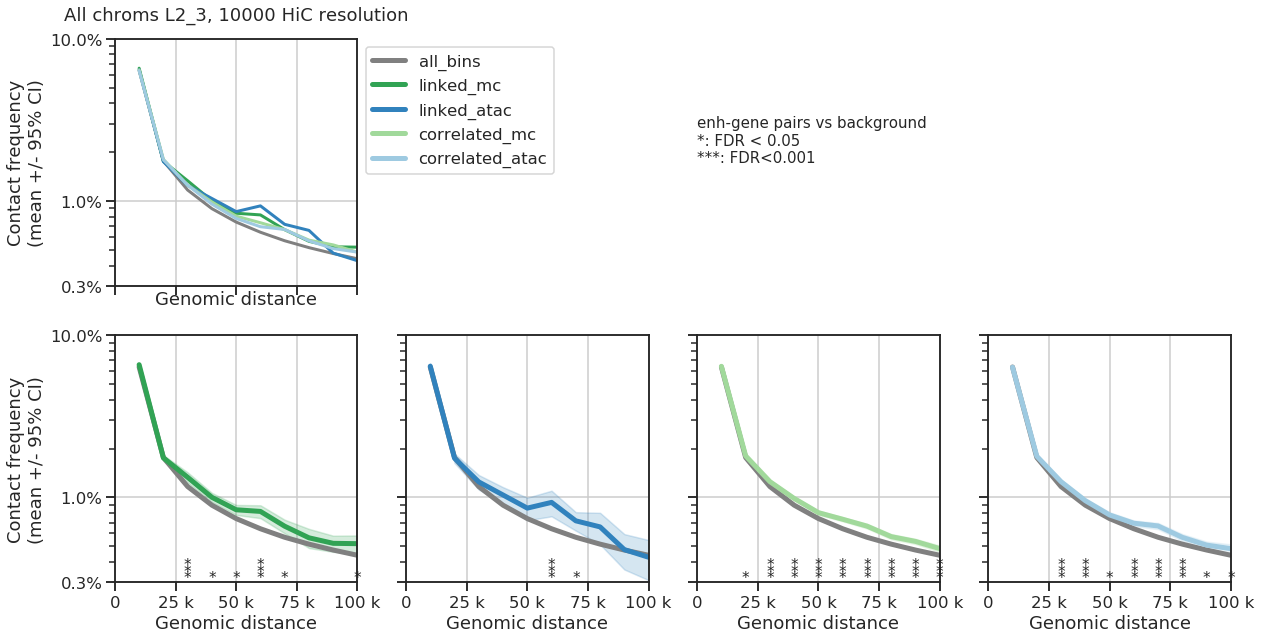

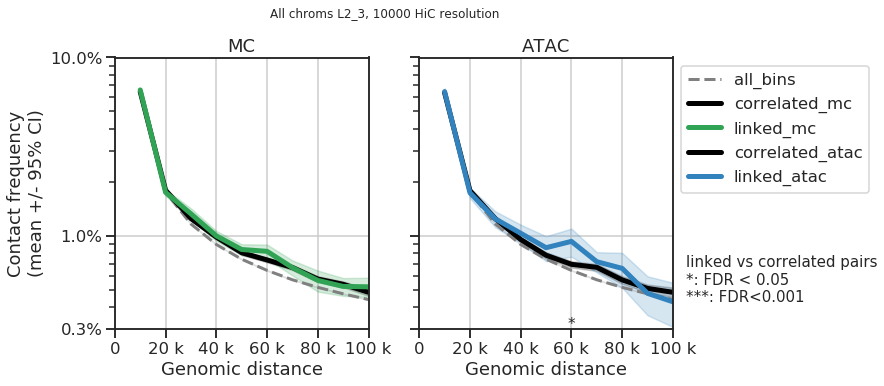

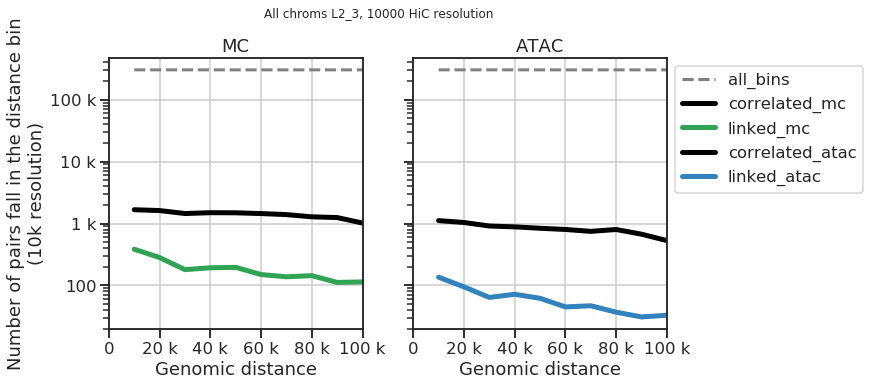

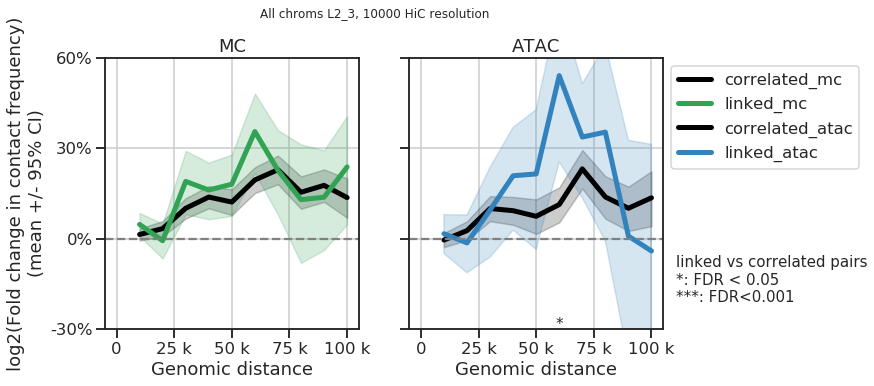

In [20]:
output_fig = ('/sphere/fangming/enhancers/scripts/figures/'
              'hic_contact_enrichment_{}_{}_plot1_v2_test.pdf'.format(celltype, resolution,)
             )

plot1_v2(distances, celltype, resolution, 
         track_names, colors,
         contacts_mean, contacts_std, contacts_n, 
         contacts_sig_pairs_mean, contacts_sig_pairs_std, contacts_sig_pairs_n,
         padjs_bck,
         output_fig,
         )

output_fig = ('/sphere/fangming/enhancers/scripts/figures/'
              'hic_contact_enrichment_{}_{}_plot1_v3_test.pdf'.format(celltype, resolution,)
             )
plot1_v3(distances, celltype, resolution, 
         track_names, colors,
         contacts_mean, contacts_std, contacts_n, 
         contacts_sig_pairs_mean, contacts_sig_pairs_std, contacts_sig_pairs_n,
         padjs_correlated,
         output_fig,
         )

output_fig = ('/sphere/fangming/enhancers/scripts/figures/'
              'hic_contact_enrichment_{}_{}_plot1_v3_cov_test.pdf'.format(celltype, resolution,)
             )
plot1_v3_cov(distances, celltype, resolution, 
         track_names, colors,
         contacts_mean, contacts_std, contacts_n, 
         contacts_sig_pairs_mean, contacts_sig_pairs_std, contacts_sig_pairs_n,
         output_fig,
         )

output_fig = ('/sphere/fangming/enhancers/scripts/figures/'
              'hic_contact_enrichment_{}_{}_plot1_v4_test.pdf'.format(celltype, resolution,)
             )
plot1_v4(distances, celltype, resolution, 
         track_names, colors,
         contacts_mean, contacts_std, contacts_n, 
         contacts_sig_pairs_mean, contacts_sig_pairs_std, contacts_sig_pairs_n,
         padjs_correlated,
         output_fig,
         )

# all cell types

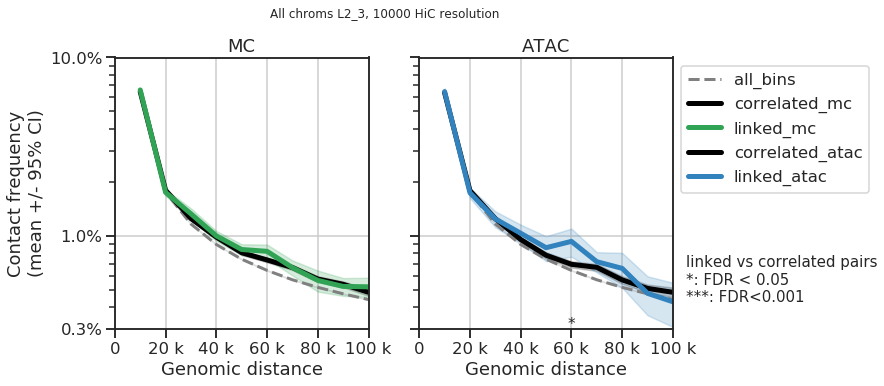

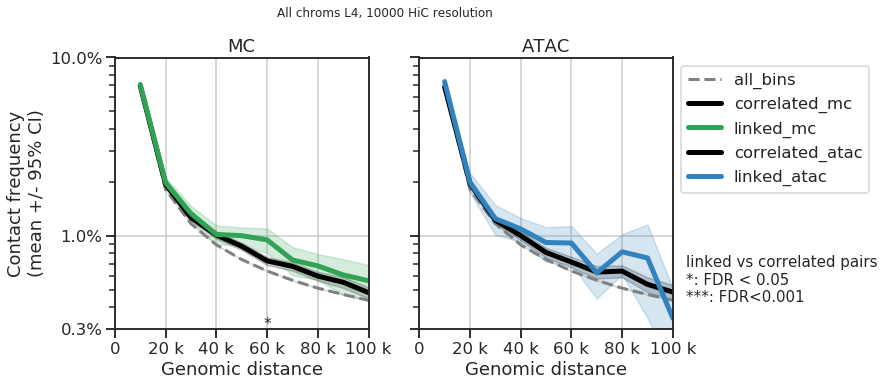

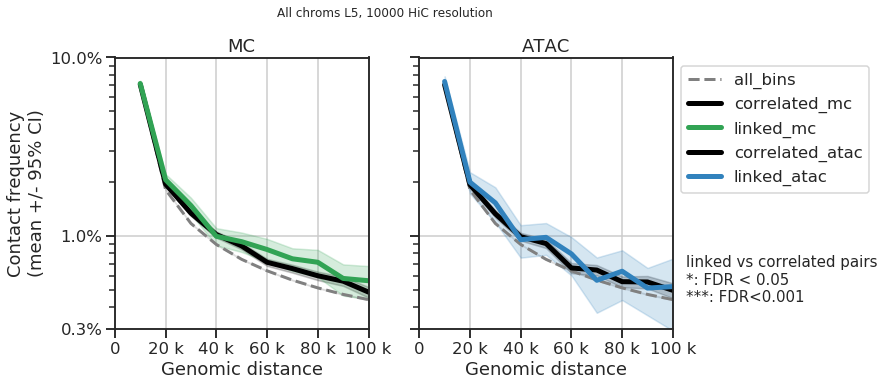

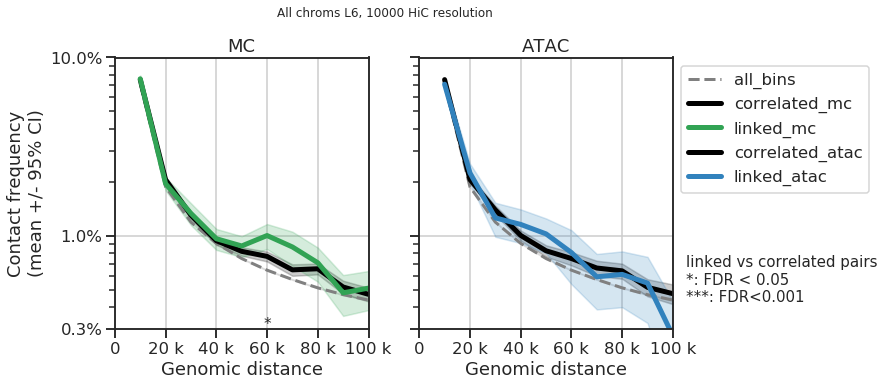

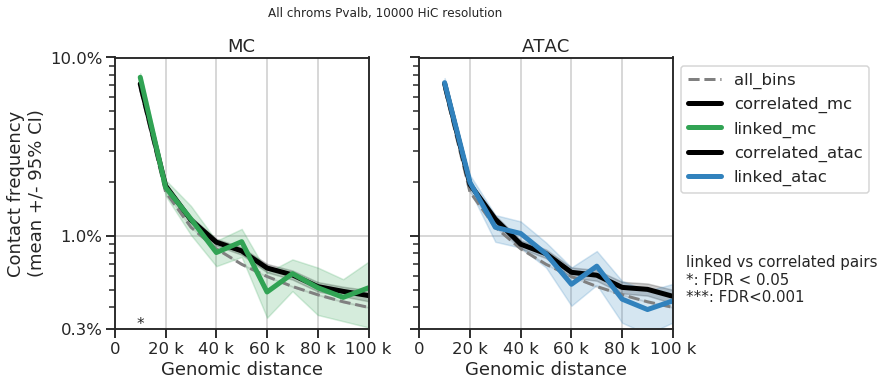

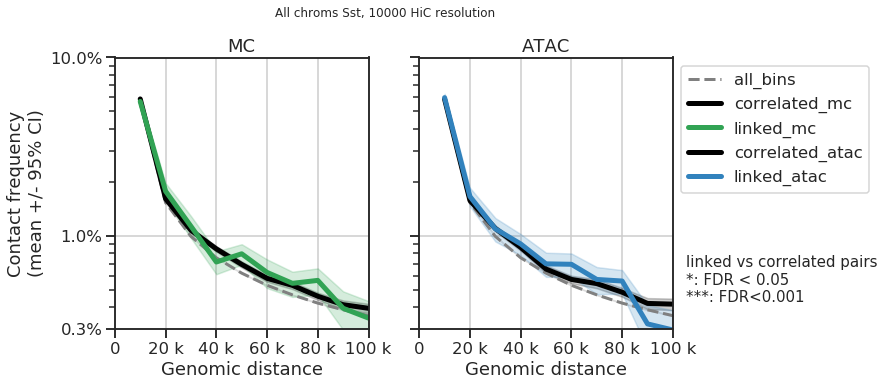

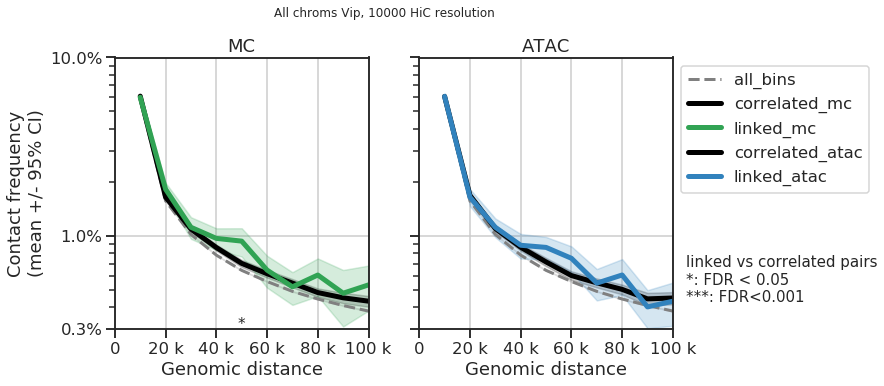

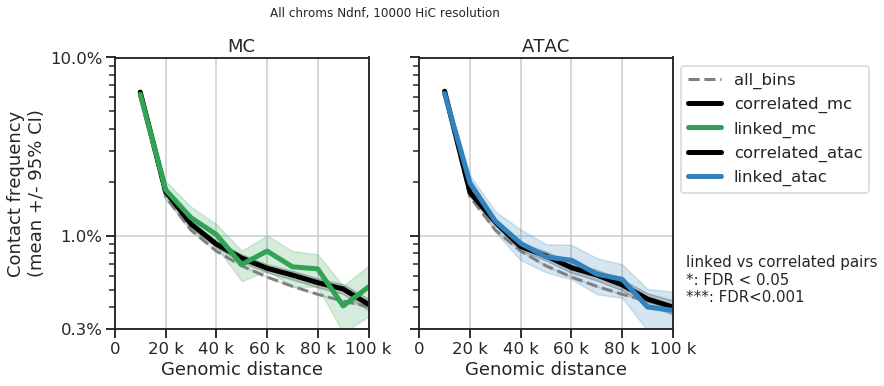

In [21]:
for celltype in celltypes:
    input_res = ('/sphere/fangming/enhancers/scripts/results_new/'
                  'hic_contact_enrichment_celltypespec_{}_{}.pkl'.format(celltype, resolution)
                 )

    # get 
    with open(input_res, 'rb') as fh:
        (distances, 
         contacts_mean, contacts_std, contacts_n,
         contacts_sig_pairs_mean, 
         contacts_sig_pairs_std, 
         contacts_sig_pairs_n, 
        ) = pickle.load(fh)

    p_th1 = 0.05
    p_th2 = 0.001

    (mean_fcs_bck, padjs_bck, 
     mean_fcs_correlated, padjs_correlated,) = ttest_routine(contacts_mean, contacts_std, contacts_n, 
                                                              contacts_sig_pairs_mean,
                                                              contacts_sig_pairs_std,
                                                              contacts_sig_pairs_n,
                                                              p_th1=p_th1, p_th2=p_th2)
    
    output_fig = ('/sphere/fangming/enhancers/scripts/figures/'
                  'hic_contact_enrichment_{}_{}_plot1_v3.pdf'.format(celltype, resolution,)
                 )
    plot1_v3(distances, celltype, resolution, 
             track_names, colors,
             contacts_mean, contacts_std, contacts_n, 
             contacts_sig_pairs_mean, contacts_sig_pairs_std, contacts_sig_pairs_n,
             padjs_correlated,
             output_fig,
             )
    
    
    p_th1 = 0.05
    p_th2 = 0.001



# Summary 1: all celltypes

In [22]:
mean_fcs_bck_all = []
mean_fcs_correlated_all = []
padjs_bck_all = []
padjs_correlated_all = []

for celltype in celltypes:
    #
    input_res = ('/sphere/fangming/enhancers/scripts/results_new/'
                  'hic_contact_enrichment_celltypespec_{}_{}.pkl'.format(celltype, resolution)
                 )

    # get 
    with open(input_res, 'rb') as fh:
        (distances, 
         contacts_mean, contacts_std, contacts_n,
         contacts_sig_pairs_mean, 
         contacts_sig_pairs_std, 
         contacts_sig_pairs_n, 
        ) = pickle.load(fh)

    p_th1 = 0.05
    p_th2 = 0.001

    # vs background
    mean_fcs_bck = collections.OrderedDict()
    padjs_bck = collections.OrderedDict()
    for key, item in contacts_sig_pairs_mean.items():
        # mean FC
        mean_fcs_bck[key] = item/contacts_mean

        # significance t-test
        t, p = stats.ttest_ind_from_stats(contacts_mean, contacts_std, contacts_n, 
                                          contacts_sig_pairs_mean[key],
                                          contacts_sig_pairs_std[key],
                                          contacts_sig_pairs_n[key],
                                          equal_var=True)
        # multiple comparison 
        _, padj, _, _ = multipletests(p, alpha=0.05, method='hs', is_sorted=False, returnsorted=False)

        # 
        padjs_bck[key] = padj

    # vs correlated
    mean_fcs_correlated = collections.OrderedDict()
    padjs_correlated = collections.OrderedDict()
    for key, item in contacts_sig_pairs_mean.items():
        if key.startswith('linked_'):
            # mean FC
            key_matched = key.replace('linked_', 'correlated_') 
            mean_fcs_correlated[key] = item/contacts_sig_pairs_mean[key_matched]

            # significance t-test
            t, p = stats.ttest_ind_from_stats( 
                                              contacts_sig_pairs_mean[key_matched],
                                              contacts_sig_pairs_std[key_matched],
                                              contacts_sig_pairs_n[key_matched],
                                              contacts_sig_pairs_mean[key],
                                              contacts_sig_pairs_std[key],
                                              contacts_sig_pairs_n[key],
                                              equal_var=True)
            # multiple comparison 
            _, padj, _, _ = multipletests(p, alpha=0.05, method='hs', is_sorted=False, returnsorted=False)

            # 
            padjs_correlated[key] = padj
    
    # ...
    
    mean_fcs_bck_all.append({'celltype': celltype, 'mean_fc': mean_fcs_bck,})
    mean_fcs_correlated_all.append({'celltype': celltype, 'mean_fc': mean_fcs_correlated,})
    padjs_bck_all.append({'celltype': celltype, 'mean_fc': padjs_bck,})
    padjs_correlated_all.append({'celltype': celltype, 'mean_fc': padjs_correlated,})
    
mean_fcs_bck_all = pd.DataFrame(mean_fcs_bck_all)
print(mean_fcs_bck_all.shape)

mean_fcs_correlated_all = pd.DataFrame(mean_fcs_correlated_all)
print(mean_fcs_correlated_all.shape)

padjs_bck_all = pd.DataFrame(padjs_bck_all)
print(padjs_bck_all.shape)

padjs_correlated_all = pd.DataFrame(padjs_correlated_all)
print(padjs_correlated_all.shape)
mean_fcs_bck_all.head()

(8, 2)
(8, 2)
(8, 2)
(8, 2)


,celltype,mean_fc
0,L2_3,"{'linked_mc': [1.03334008988, 0.995326177153, ..."
1,L4,"{'linked_mc': [1.0422175789, 1.09234300383, 1...."
2,L5,"{'linked_mc': [1.02259521896, 1.13664323878, 1..."
3,L6,"{'linked_mc': [1.06650392507, 1.04258482371, 1..."
4,Pvalb,"{'linked_mc': [1.15246075865, 1.06059880218, 1..."


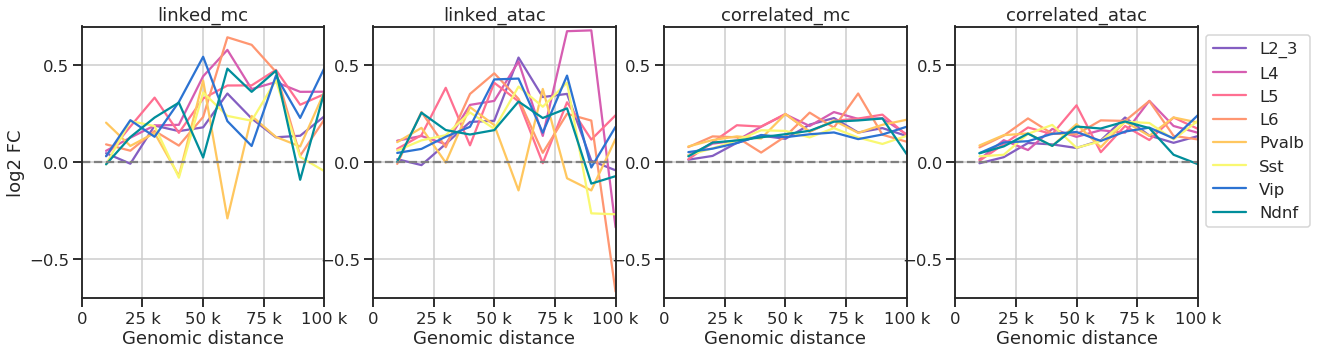

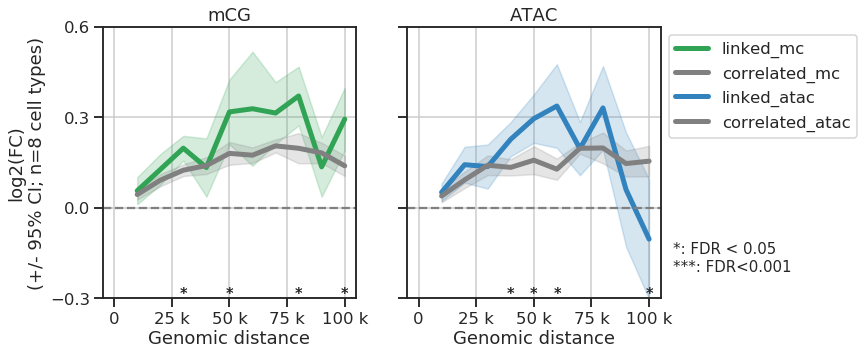

In [23]:
output_fig = ('/sphere/fangming/enhancers/scripts/figures/'
              'hic_contact_enrichment_celltypespec_summarized_FC.pdf'
             )
p_th = 0.05
plot2(distances, track_names, mean_fcs_bck_all, 
      colors, celltype_palette, 
      output_fig)

output_fig = ('/sphere/fangming/enhancers/scripts/figures/'
              'hic_contact_enrichment_celltypespec_summarized_FC_v2.pdf'
             )
plot3(distances, mean_fcs_bck_all, 
      track_names, colors_contrast, padjs_bck_all,
      output_fig)

# Summary 2: combine all cell types into 1 track

- reconcile 8 different (mean, std, n)

In [24]:
def aggregate_mean_std(mu, sigma, n):
    """Given a list of mu, sigma, n 
    return the aggregated mu, sigma, n    
    """
    mu = np.array(mu)
    sigma = np.array(sigma)
    n = np.array(n)
    
    n_agg = np.sum(n)
    
    ratio = n/n_agg
    mu_agg = np.dot(ratio, mu)
    sigma_agg = np.sqrt(np.dot(ratio, np.power(sigma, 2)) 
                      + np.dot(ratio, np.power((mu-mu_agg), 2))
                       )
    return mu_agg, sigma_agg, n_agg

def aggregate_mean_std_matrix(mu, sigma, n):
    """Given a matrix of mu, sigma, n  
    return the aggregated array mu, sigma, n (remove the first matrix axis) 
    """
    mu = np.array(mu)
    sigma = np.array(sigma)
    n = np.array(n)
    nrow, ncol = mu.shape
    
    mu_agg_all = []
    sigma_agg_all = []
    n_agg_all = []
    for col_idx in np.arange(ncol):
        mu_agg, sigma_agg, n_agg = aggregate_mean_std(mu[:,col_idx], sigma[:,col_idx], n[:,col_idx])
        mu_agg_all.append(mu_agg)
        sigma_agg_all.append(sigma_agg)
        n_agg_all.append(n_agg)
        
    return np.array(mu_agg_all), np.array(sigma_agg_all), np.array(n_agg_all)

In [25]:
# combine all cell types

contacts_mean_all = []
contacts_std_all = []
contacts_n_all = []

contacts_sig_pairs_mean_all = {track: [] for track in track_names}
contacts_sig_pairs_std_all = {track: [] for track in track_names}
contacts_sig_pairs_n_all = {track: [] for track in track_names}


for celltype in celltypes:
    input_res = ('/sphere/fangming/enhancers/scripts/results_new/'
                  'hic_contact_enrichment_celltypespec_{}_{}.pkl'.format(celltype, resolution)
                 )

    # get 
    with open(input_res, 'rb') as fh:
        (distances, 
         contacts_mean, contacts_std, contacts_n,
         contacts_sig_pairs_mean, 
         contacts_sig_pairs_std, 
         contacts_sig_pairs_n, 
        ) = pickle.load(fh)

    # contacts: by regions -> celltype by regions -> by regions
    contacts_mean_all.append(contacts_mean)
    contacts_std_all.append(contacts_std)
    contacts_n_all.append(contacts_n)
    
    # contacts_sig_pairs: key by regions -> key by (celltype by regions) -> key by regions
    for key in contacts_sig_pairs_mean.keys():
        contacts_sig_pairs_mean_all[key].append(contacts_sig_pairs_mean[key])
        contacts_sig_pairs_std_all[key].append(contacts_sig_pairs_std[key])
        contacts_sig_pairs_n_all[key].append(contacts_sig_pairs_n[key])
    
# celltype by region 
contacts_mean_all = np.array(contacts_mean_all)
contacts_std_all = np.array(contacts_std_all)
contacts_n_all = np.array(contacts_n_all)
for key in contacts_sig_pairs_mean_all.keys():
    contacts_sig_pairs_mean_all[key] = np.array(contacts_sig_pairs_mean_all[key])
    contacts_sig_pairs_std_all[key] = np.array(contacts_sig_pairs_std_all[key])
    contacts_sig_pairs_n_all[key] = np.array(contacts_sig_pairs_n_all[key])

# by region
(contacts_mean_agg, contacts_std_agg, contacts_n_agg,
) = aggregate_mean_std_matrix(contacts_mean_all, contacts_std_all, contacts_n_all)
 
# key by region
contacts_sig_pairs_mean_agg = {track: [] for track in track_names}
contacts_sig_pairs_std_agg = {track: [] for track in track_names}
contacts_sig_pairs_n_agg = {track: [] for track in track_names}
for key in contacts_sig_pairs_mean_all.keys():
    (contacts_sig_pairs_mean_agg[key], 
     contacts_sig_pairs_std_agg[key], 
     contacts_sig_pairs_n_agg[key], 
    ) = aggregate_mean_std_matrix(contacts_sig_pairs_mean_all[key], 
                                  contacts_sig_pairs_std_all[key], 
                                  contacts_sig_pairs_n_all[key], 
                                 )
    
# # check dimensions
# print(contacts_mean_agg.shape, 
#       contacts_std_agg.shape, 
#       contacts_n_agg.shape, 
#      )
# for key in contacts_sig_pairs_mean_all.keys():
#     print(contacts_sig_pairs_mean_agg[key].shape, 
#           contacts_sig_pairs_std_agg[key].shape, 
#           contacts_sig_pairs_n_agg[key].shape, 
#          )

p_th1 = 0.05
p_th2 = 0.001
(mean_fcs_bck, padjs_bck, 
 mean_fcs_correlated, padjs_correlated,) = ttest_routine(contacts_mean_agg, 
                                                         contacts_std_agg, 
                                                         contacts_n_agg, 
                                                         contacts_sig_pairs_mean_agg,
                                                         contacts_sig_pairs_std_agg,
                                                         contacts_sig_pairs_n_agg,
                                                         p_th1=p_th1, p_th2=p_th2)

/sphere/fangming/enhancers/scripts/figures/hic_contact_enrichment_agg_8celltypes_10000_plot1_v3.pdf


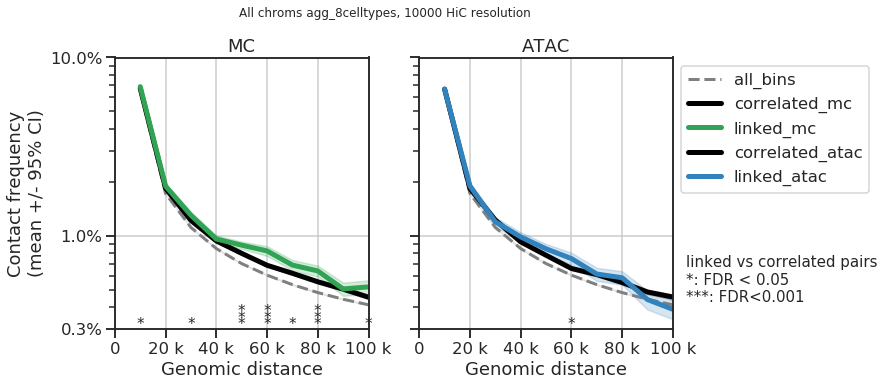

In [26]:
celltype = 'agg_8celltypes'
output_fig = ('/sphere/fangming/enhancers/scripts/figures/'
              'hic_contact_enrichment_{}_{}_plot1_v3.pdf'.format(celltype, resolution,)
             )
print(output_fig)
plot1_v3(distances, celltype, resolution, 
         track_names, colors,
         contacts_mean_agg, contacts_std_agg, contacts_n_agg, 
         contacts_sig_pairs_mean_agg, contacts_sig_pairs_std_agg, contacts_sig_pairs_n_agg,
         padjs_correlated,
         output_fig,
         )

/sphere/fangming/enhancers/scripts/figures/hic_contact_enrichment_agg_8celltypes_10000_plot1_v4.pdf


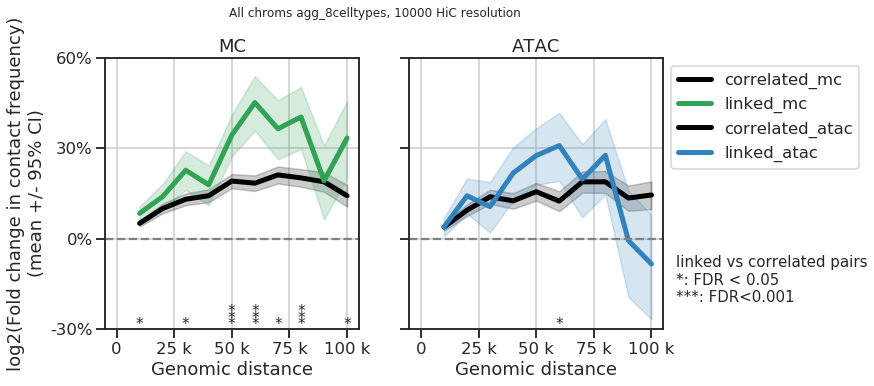

In [27]:
# fold change plot1_v4
celltype = 'agg_8celltypes'
output_fig = ('/sphere/fangming/enhancers/scripts/figures/'
              'hic_contact_enrichment_{}_{}_plot1_v4.pdf'.format(celltype, resolution,)
             )
print(output_fig)
plot1_v4(distances, celltype, resolution, 
         track_names, colors,
         contacts_mean_agg, contacts_std_agg, contacts_n_agg, 
         contacts_sig_pairs_mean_agg, contacts_sig_pairs_std_agg, contacts_sig_pairs_n_agg,
         padjs_correlated,
         output_fig,
         )